# Project: Credit Risk Analysis

This project aims to calculate credit risk RWA and capital requirements for a mortgage portfolio using the provided Mortgage_default dataset. We will compute RWA under both the standardized and IRB approaches, apply a PD model (without evaluating goodness of fit), handle missing collateral by using a default LTV of 0.45, and compare results. The final deliverable includes visualization and brief commentary on insights.

[Link to dataset](https://docs.google.com/spreadsheets/d/1t3h7rt3_ODqsCYgl5Ca74LN5Ldb8oj2foBSLPtMpJcU/edit?usp=sharing)

Notebook Structure:
- Import Librairies
- Import Data
- Data Cleaning
- Exploratory Data Analysis
- Risk-Weighted Assets (RWA) using Standardised Approach (SA)
- Risk-Weighted Assets (RWA) using Internal Ratings-Based (IRB) Approach
- Results Visualization
- Insights and Recommendations

### Import Librairies

In [433]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from scipy.stats import norm
from typing import Dict

import warnings
warnings.filterwarnings('ignore')

### Import data

In [434]:
df = pd.read_csv('Mortgage_default.csv')
df

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


The dataset contains 11 features and 5960 observations.

In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   MORTDUE  5442 non-null   float64
 2   VALUE    5848 non-null   float64
 3   JOB      5681 non-null   object 
 4   YOJ      5445 non-null   float64
 5   DEROG    5252 non-null   float64
 6   DELINQ   5380 non-null   float64
 7   CLAGE    5652 non-null   float64
 8   NINQ     5450 non-null   float64
 9   CLNO     5738 non-null   float64
 10  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 512.3+ KB


Most features are floats, with only one integer (BAD) and one object (JOB) datatype

Description of the data columns:
- BAD: 1 = applicant defaulted on loan or seriously delinquent; 0 = applicant paid loan.
- MORTDUE: Amount due on an existing mortgage.
- VALUE: Value of current property.
- JOB: Occupational categories.
- YOJ: Years at present job.
- DEROG: Number of major derogatory reports (The number of serious negative marks on their credit history e.g Bankruptcy, Foreclosure etc. Higher values = worse credit history).
- DELINQ: Number of delinquent credit lines (Number of credit accounts where the applicant has been late on payments)
- CLAGE: Age of oldest credit line in months.
- NINQ: Number of recent credit inquiries (How many times the applicant has recently applied for credit e.g. loan, credit card applications, etc. High values may indicate financial stress or aggressive credit-seeking behavior)
- CLNO: Number of credit lines. (Total number of credit accounts the person has, e.g Credit cards, Loans, Mortgages etc)
- DEBTINC: Debt-to-income ratio. (Measures how much of the applicant’s income is used to pay debt)

### Data Cleaning

Let's check the missing values.

In [436]:
df.isnull().sum()

BAD           0
MORTDUE     518
VALUE       112
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

The dataset contains a lot of missing values. We will then proceed to data cleaning. Data cleaning steps followed:

- Removed rows where both MORTDUE and VALUE were missing.

- Created a new feature/column LTV (MORTDUE / VALUE).

- For rows missing either MORTDUE or VALUE, assumed an LTV of 0.45 to reconstruct the missing value and ensure consistency.

- Filled missing JOB values with "Undefined".


Imputed missing values with the median for the following variables:

- YOJ

- CLAGE

- DEBTINC

- CLNO

Imputed missing NINQ, DEROG and DELINQ values with the mode (0).

In [437]:
# Drop rows where both MORTDUE and VALUE are missing
df = df.dropna(subset=['MORTDUE', 'VALUE'], how='all')

# Fill missing MORTDUE or VALUE assuming LTV of 0.45
ltv_assumed = 0.45

# If MORTDUE is missing but VALUE is present
mask_mortdue_missing = df['MORTDUE'].isna() & df['VALUE'].notna()
df.loc[mask_mortdue_missing, 'MORTDUE'] = ltv_assumed * df.loc[mask_mortdue_missing, 'VALUE']

# If VALUE is missing but MORTDUE is present
mask_value_missing = df['VALUE'].isna() & df['MORTDUE'].notna()
df.loc[mask_value_missing, 'VALUE'] = df.loc[mask_value_missing, 'MORTDUE'] / ltv_assumed

# Create LTV column as MORTDUE / VALUE
df['LTV'] = df['MORTDUE'] / df['VALUE']

# Impute JOB missing values with "Undefined"
df['JOB'] = df['JOB'].fillna('Undefined')

# Impute selected numeric columns with their median
median_cols = ['YOJ', 'CLAGE', 'DEBTINC', 'CLNO']
for col in median_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Impute NINQ, DEROG and DELINQ missing values with mode (0)
mode_fill_cols = ['NINQ', 'DEROG', 'DELINQ']
for col in mode_fill_cols:
    df[col] = df[col].fillna(0)

# Quick check of remaining missing values
df.isnull().sum()

BAD        0
MORTDUE    0
VALUE      0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
LTV        0
dtype: int64

In [438]:
df

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,LTV
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.834830,0.662652
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.834830,1.024167
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.834830,0.808383
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.834830,0.873214
5,1,30548.0,40320.0,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,0.757639
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.634961
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.587237
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.581604
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.548328


The dataset is now complete

### Exploratory Data Analysis

Let's check for outliers

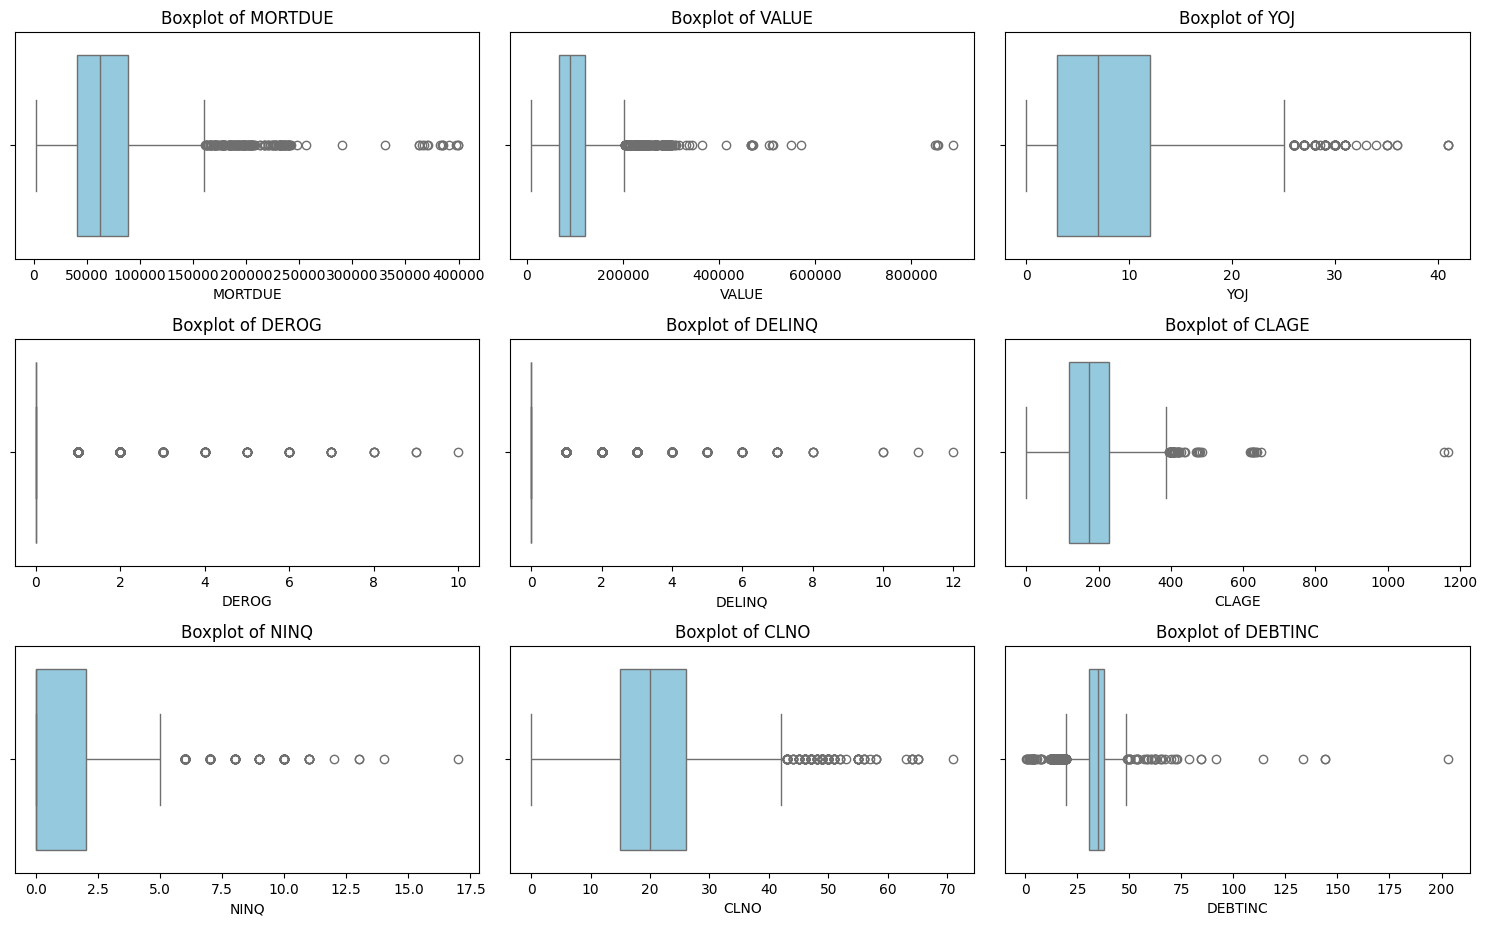

In [439]:
features = ['MORTDUE', 'VALUE', 'YOJ', 'DEROG','DELINQ','CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=X_train[feature], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel(feature)

for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

The boxplots reveal several right-skewed distributions with notable high-value outliers:

- MORTDUE shows a wide spread with many high-value outliers, meaning most applicants have moderate mortgage debt while a small group carries exceptionally large balances.
- VALUE displays a similarly broad upper range, with typical property values clustered lower and a few very expensive homes creating extreme outliers.
- YOJ is right-skewed, indicating most applicants have short job tenure, while only a small number show very long employment histories.
- DEROG is mostly zero, showing that severe credit issues are rare, with only a few applicants having multiple major derogatory events.
- DELINQ is also concentrated near zero, suggesting most applicants rarely miss payments, while a minority have repeated delinquencies.
- CLAGE has a stable central range but some very high values, reflecting a small group with exceptionally long-established credit histories.
- NINQ consists mostly of low integer values, with limited cases of very high inquiry counts indicating more aggressive credit-seeking behavior.
- CLNO is mainly between 10 and 40, with outliers above 50 pointing to unusually large credit portfolios.
- DEBTINC shows several extreme high ratios, meaning most applicants have manageable debt burdens while a few face significantly higher financial strain.

We will now visualize the distribution of defaulted vs non-defaulted loan

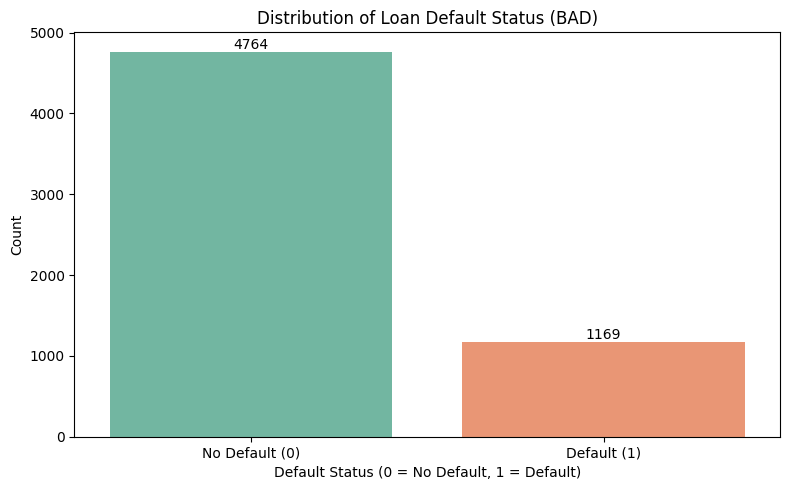

Default Rate: 19.70%


In [440]:
# Bar chart: distribution of BAD (default status)
bad_counts = df['BAD'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=bad_counts.index, y=bad_counts.values, palette='Set2', ax=ax)
ax.set_title('Distribution of Loan Default Status (BAD)')
ax.set_xlabel('Default Status (0 = No Default, 1 = Default)')
ax.set_ylabel('Count')
ax.set_xticklabels(['No Default (0)', 'Default (1)'])

# Annotate counts on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Display default rate
default_rate = bad_counts[1] / bad_counts.sum()
print(f"Default Rate: {default_rate:.2%}")

We have around 19% of observations which include defaulted loans

Let's look at the job types included in the data set

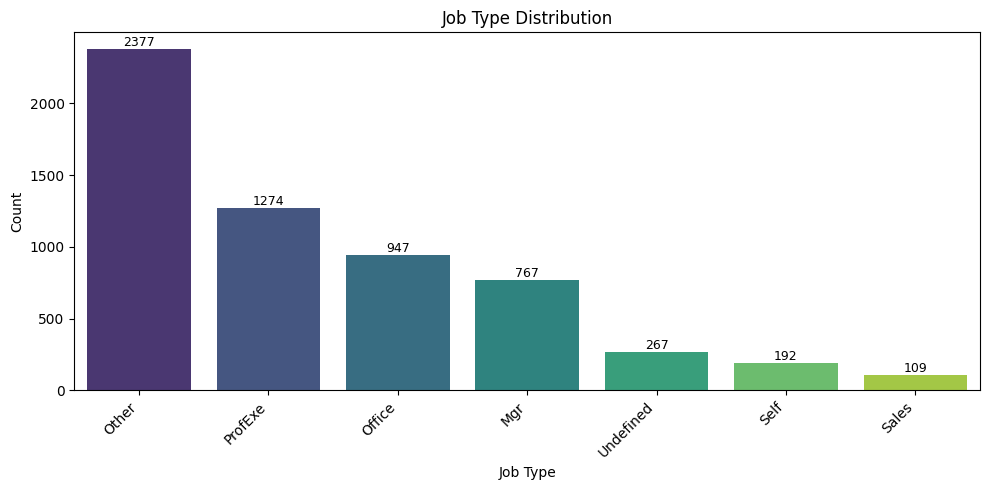

In [441]:
# Bar chart: distribution of JOB types
job_counts = df['JOB'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=job_counts.index, y=job_counts.values, palette='viridis', ax=ax)
ax.set_title('Job Type Distribution')
ax.set_xlabel('Job Type')
ax.set_ylabel('Count')

# Annotate counts on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Most jobs included in the JOB feature are "Other"

Correlation matrix

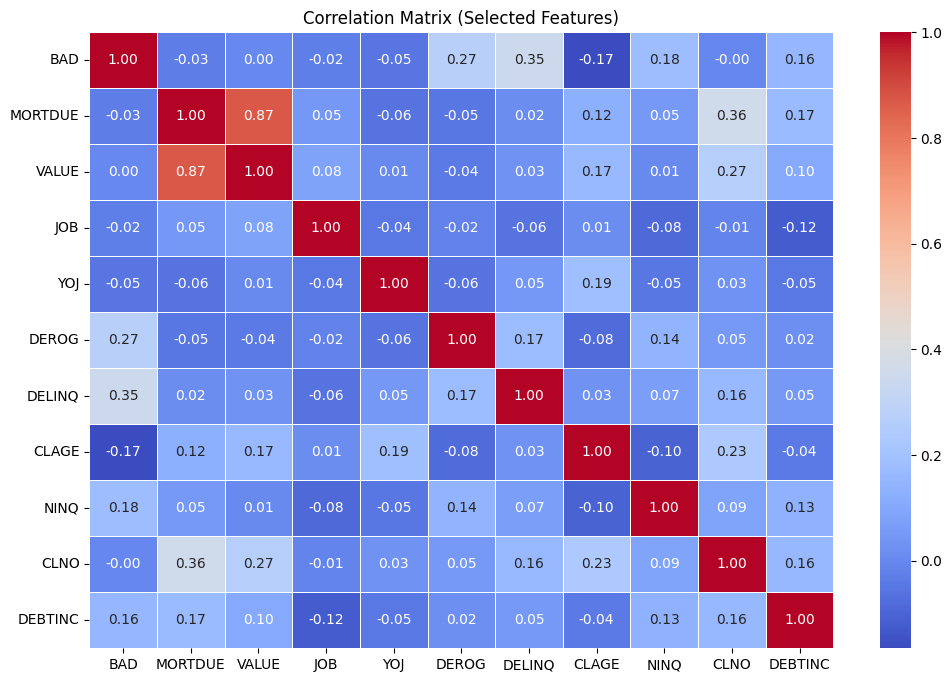

In [442]:
# Correlation matrix visualization (selected features)
corr_features = ['BAD', 'MORTDUE', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
corr_df = df[corr_features].copy()

# Encode JOB to numeric codes so it can be included in the correlation matrix
corr_df['JOB'] = corr_df['JOB'].astype('category').cat.codes

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Selected Features)')
plt.show()

- Strong positive correlation: MORTDUE–VALUE (0.87) — Higher mortgage balances are strongly associated with higher property values, which is expected.

- Weak relationship with default (BAD): Most variables such as MORTDUE, VALUE, YOJ, CLNO show correlations near zero, indicating very weak linear relationships with default risk.

- Moderate correlations with BAD: DELINQ (0.35) and DEROG (0.27) have the strongest positive correlations with BAD, meaning past delinquencies and derogatory reports are more indicative of default.

- Other correlations: All remaining feature pairs show low correlations, suggesting limited linear dependency across most variables.

### RWA using Standardized Approach

RWA (Risk-Weighted Assets) using the standardized approach is a method banks use to calculate the capital they must hold against credit risk, following regulatory rules under Basel III framework.

We will calculate RWA for the mortgage portfolio using the Standardized Approach based on LTV (Loan-to-Value) ratios. The steps are:

- EAD (Exposure at Default): Duplicates the MORTDUE column to represent the amount at risk for each loan.

- RW (Risk Weight): We will assigned RW based on the LTV

    `LTV > 1 → RW = 0.7`

    `0.9 < LTV ≤ 1 → RW = 0.5`

    `0.8 < LTV ≤ 0.9 → RW = 0.4`

    `0.6 < LTV ≤ 0.8 → RW = 0.3`

    `0.5 < LTV ≤ 0.6 → RW = 0.25`

    `LTV ≤ 0.5 → RW = 0.2`

- Risk-Weighted Assests: `RWA=EAD×RW`

- Capital Requirement: `CR=RWA×8%`

- Tier 1 of capital requirement: `T1_CR=RWAx6%`

In [443]:
# Create EAD as a copy of MORTDUE

df['EAD'] = df['MORTDUE']

# Create RW based on LTV

def compute_rw(row):
    if row['LTV'] > 1:
        return 0.7
    elif row['LTV'] > 0.9:
        return 0.5
    elif row['LTV'] > 0.8:
        return 0.4
    elif row['LTV'] > 0.6:
        return 0.3
    elif row['LTV'] > 0.5:
        return 0.25
    else:
        return 0.2

df['RW'] = df.apply(compute_rw, axis=1)

# RWA is EAD * RW

df['RWA_SA'] = df['EAD'] * df['RW']

# Capital is 8% of RWA

df['CR_SA'] = df['RWA_SA'] * 0.08

#Tier 1 of capital requirement (6% of RWA)

df['T1_CR_SA'] = df['RWA_SA'] * 0.06

# Quick check of the new columns

df

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,LTV,EAD,RW,RWA_SA,CR_SA,T1_CR_SA
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.834830,0.662652,25860.0,0.30,7758.00,620.640,465.480
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.834830,1.024167,70053.0,0.70,49037.10,3922.968,2942.226
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.834830,0.808383,13500.0,0.40,5400.00,432.000,324.000
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.834830,0.873214,97800.0,0.40,39120.00,3129.600,2347.200
5,1,30548.0,40320.0,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,0.757639,30548.0,0.30,9164.40,733.152,549.864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.634961,57264.0,0.30,17179.20,1374.336,1030.752
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.587237,54576.0,0.25,13644.00,1091.520,818.640
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.581604,54045.0,0.25,13511.25,1080.900,810.675
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.548328,50370.0,0.25,12592.50,1007.400,755.550


### RWA using IRB approach

RWA (Risk-Weighted Assets) using the IRB (Internal Ratings-Based) approach is a more risk-sensitive way of calculating capital requirements compared to the standardized approach. Unlike standardized, which uses regulator-set risk weights, the IRB approach allows banks to use their internal models to estimate key credit risk parameters for each exposure.


We first start preparing the dataset and building the model by calculating the probability of default (PD) using logistic regression, which will be used later in the RWA and CR calculation formula later on

First we split dataset into features (X) and the target variable (y)

In [444]:
X = df[['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']]
y = df['BAD']

Next, we split the data into training and testing set

In [445]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next, we scale the data so we can normalize the numerical features

In [446]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We then fit the logistic regression model

In [447]:
model = LogisticRegression(max_iter=3000, solver='liblinear')
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,3000
,multi_class,'deprecated'


We then get the predicted probabilities for the positive class (given default=1)

In [448]:
df['PD'] = model.predict_proba(X)[:, 1]

df[['BAD','MORTDUE','VALUE','JOB','YOJ','DEROG','DELINQ', 'CLAGE','NINQ','CLNO','DEBTINC','LTV','EAD','PD']]

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,LTV,EAD,PD
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.834830,0.662652,25860.0,0.319490
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.834830,1.024167,70053.0,0.227463
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.834830,0.808383,13500.0,0.232699
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.834830,0.873214,97800.0,0.268651
5,1,30548.0,40320.0,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,0.757639,30548.0,0.299481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.634961,57264.0,0.152475
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.587237,54576.0,0.172263
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.581604,54045.0,0.169241
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.548328,50370.0,0.171922


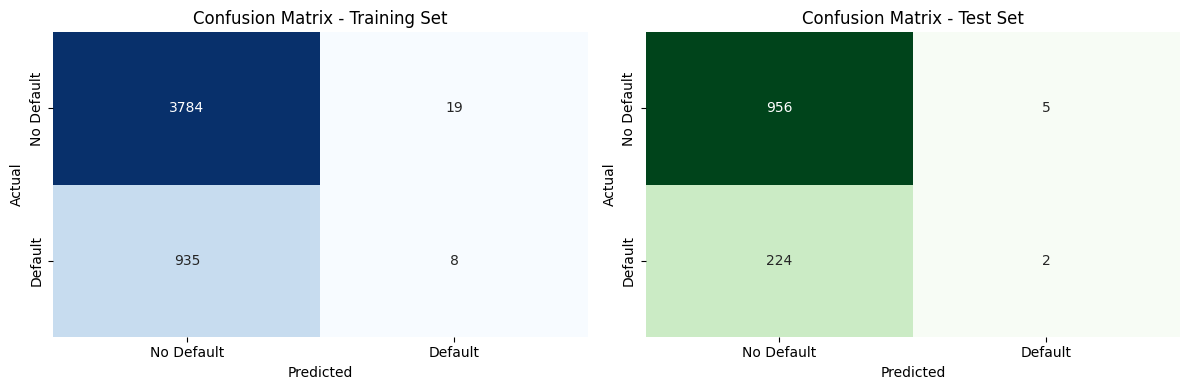

Train Accuracy: 0.7990
Test Accuracy: 0.8071


In [449]:
# Create confusion matrices for train and test sets
cm_train = confusion_matrix(y_train, model.predict(X_train))
cm_test = confusion_matrix(y_test, model.predict(X_test))

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix - Training Set')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Default', 'Default'])
axes[0].set_yticklabels(['No Default', 'Default'])

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix - Test Set')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['No Default', 'Default'])
axes[1].set_yticklabels(['No Default', 'Default'])

plt.tight_layout()
plt.show()

# Print accuracy scores
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

- The model almost always predicts No Default.
- Defaults are rarely detected: only 8/935 in training, 2/224 in testing.
- Severe class imbalance causes bias toward the majority class.

In [450]:
# Generate classification report on testing set
y_test_pred = model.predict(X_test)
print("Classification Report - Test Set")
print("=" * 50)
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))

Classification Report - Test Set
              precision    recall  f1-score   support

  No Default       0.81      0.99      0.89       961
     Default       0.29      0.01      0.02       226

    accuracy                           0.81      1187
   macro avg       0.55      0.50      0.46      1187
weighted avg       0.71      0.81      0.73      1187



Interpretation

No Default:

- The precision is 0.81 and recall 0.99, which accurately identifies most non-defaults.

- F1-score is 0.89 which shows strong performance for majority class.

Default:

- Precision is 0.29 and recall 0.01, which means the model identifies a few default cases, showing initial signals it can learn from the minority class.

- F1-score is 0.02 which is not ideal but could be used as an opportunity to improve detection of risky clients through additional techniques.

Next, we will now calculate the IRB RWA and capital requirements using the formula under BASEL III framework:

- LGD (Loss Given Default): `LGD = 0.45`

- Maturity (b): `b = (0.11852 - 0.05478 * math.log(PD)) ** 2`

- Correlation (R): `R = 0.12 * ((1 - math.exp(-50 * PD)) / (1 - math.exp(-50))) + 0.24 * (1 - (1 - math.exp(-50 * PD)) / (1 - math.exp(-50)))`

- Capital requirement (K): `K = LGD * norm.cdf((1 / np.sqrt(1 - R)) * norm.ppf(PD) + np.sqrt(R / (1 - R)) * norm.ppf(0.999)) - PD * LGD`

- RWA under IRB: `RWA_IRB = K * 12.5 * EAD`

- Capital requirement (CR) under IRB: `CR_IRB = RWA_IRB * 0.08`

- Tier 1 capital requirement under IRB: `T1_CR_IRB = RWA_IRB * 0.06`


In [451]:
# Column 1: LGD
df['LGD'] = LGD

# Column 2: b (maturity adjustment factor)
df['b'] = (0.11852 - 0.05478 * np.log(df['PD'])) ** 2

# Column 3: R (correlation)
df['R'] = 0.12 * ((1 - np.exp(-50 * df['PD'])) / (1 - np.exp(-50))) + \
          0.24 * (1 - (1 - np.exp(-50 * df['PD'])) / (1 - np.exp(-50)))

# Column 4: K (capital requirement)
df['K'] = df['LGD'] * norm.cdf((1 / np.sqrt(1 - df['R'])) * norm.ppf(df['PD']) + 
                                np.sqrt(df['R'] / (1 - df['R'])) * norm.ppf(0.999)) - \
          df['PD'] * df['LGD']

# Column 5: RWA_IRB (using Basel formula)
df['RWA_IRB'] = df['K'] * 12.5 * df['EAD']

# Column 6: CR_IRB (8% capital requirement)
df['CR_IRB'] = df['RWA_IRB'] * 0.08

# Column 7: T1_CR_IRB (6% Tier 1 capital requirement)
df['T1_CR_IRB'] = df['RWA_IRB'] * 0.06

# Display sample results
df[['BAD','MORTDUE','VALUE','JOB','YOJ','DEROG','DELINQ',
         'CLAGE','NINQ','CLNO','DEBTINC','EAD','PD', 'LGD', 'b', 'R', 'K', 'RWA_IRB', 'CR_IRB', 'T1_CR_IRB']]

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,EAD,PD,LGD,b,R,K,RWA_IRB,CR_IRB,T1_CR_IRB
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.834830,25860.0,0.319490,0.45,0.032770,0.120000,0.188895,61060.268757,4884.821501,3663.616125
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.834830,70053.0,0.227463,0.45,0.039855,0.120001,0.183303,160511.786282,12840.942903,9630.707177
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.834830,13500.0,0.232699,0.45,0.039359,0.120001,0.184046,31057.757386,2484.620591,1863.465443
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.834830,97800.0,0.268651,0.45,0.036298,0.120000,0.187645,229396.058940,18351.684715,13763.763536
5,1,30548.0,40320.0,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,30548.0,0.299481,0.45,0.034066,0.120000,0.188885,72125.583734,5770.046699,4327.535024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,57264.0,0.152475,0.45,0.049083,0.120059,0.164971,118086.175285,9446.894023,7085.170517
5956,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,54576.0,0.172263,0.45,0.046166,0.120022,0.171395,116925.482313,9354.038585,7015.528939
5957,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,54045.0,0.169241,0.45,0.046584,0.120025,0.170497,115181.338478,9214.507078,6910.880309
5958,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,50370.0,0.171922,0.45,0.046213,0.120022,0.171295,107851.396278,8628.111702,6471.083777


### Summary of metrics

As a final step of out calculations, we will compute a sum of metrics while making sure to include only non-defaulted loans

In [452]:
#Filter for non-defaulted loans only (BAD = 0)
df_non_default = df[df['BAD'] == 0]

# Calculate totals for standardized approach
ead_std_total = df_non_default['EAD'].sum()
rwa_std_total = df_non_default['RWA_SA'].sum()
cr_std_total = df_non_default['CR_SA'].sum()
t1cr_std_total = df_non_default['T1_CR_SA'].sum()
rw_std_pct = (rwa_std_total / ead_std_total * 100)

# Calculate totals for IRB approach
ead_irb_total = df_non_default['EAD'].sum()
rwa_irb_total = df_non_default['RWA_IRB'].sum()
cr_irb_total = df_non_default['CR_IRB'].sum()
t1cr_irb_total = df_non_default['T1_CR_IRB'].sum()
rw_irb_pct = (rwa_irb_total / ead_irb_total * 100)

# Build summary table
summary_non_default = pd.DataFrame(
    {
        'Standardized approach': [ead_std_total, rwa_std_total, cr_std_total, t1cr_std_total, rw_std_pct],
        'IRB approach': [ead_irb_total, rwa_irb_total, cr_irb_total, t1cr_irb_total, rw_irb_pct],
    },
    index=['Exposure at Default', 'Risk-Weighted Asset', 'Capital Requirement (8%)', 'Tier 1 CR (6%)', 'RW (%)']
)

# Format the summary table: monetary values as currency, RW as percentage
summary_formatted = summary_non_default.copy()

# Format monetary rows (first 4 rows) as currency with commas
monetary_rows = ['Exposure at Default', 'Risk-Weighted Asset', 'Capital Requirement (8%)', 'Tier 1 CR (6%)']
for row in monetary_rows:
    summary_formatted.loc[row, 'Standardized approach'] = f"${summary_non_default.loc[row, 'Standardized approach']:,.0f}"
    summary_formatted.loc[row, 'IRB approach'] = f"${summary_non_default.loc[row, 'IRB approach']:,.0f}"

# Format RW row as percentage
summary_formatted.loc['RW (%)', 'Standardized approach'] = f"{summary_non_default.loc['RW (%)', 'Standardized approach']:.2f}%"
summary_formatted.loc['RW (%)', 'IRB approach'] = f"{summary_non_default.loc['RW (%)', 'IRB approach']:.2f}%"

summary_formatted

,Standardized approach,IRB approach
Exposure at Default,"$337,378,613","$337,378,613"
Risk-Weighted Asset,"$109,814,353","$687,654,320"
Capital Requirement (8%),"$8,785,148","$55,012,346"
Tier 1 CR (6%),"$6,588,861","$41,259,259"
RW (%),32.55%,203.82%


### Results Visualization

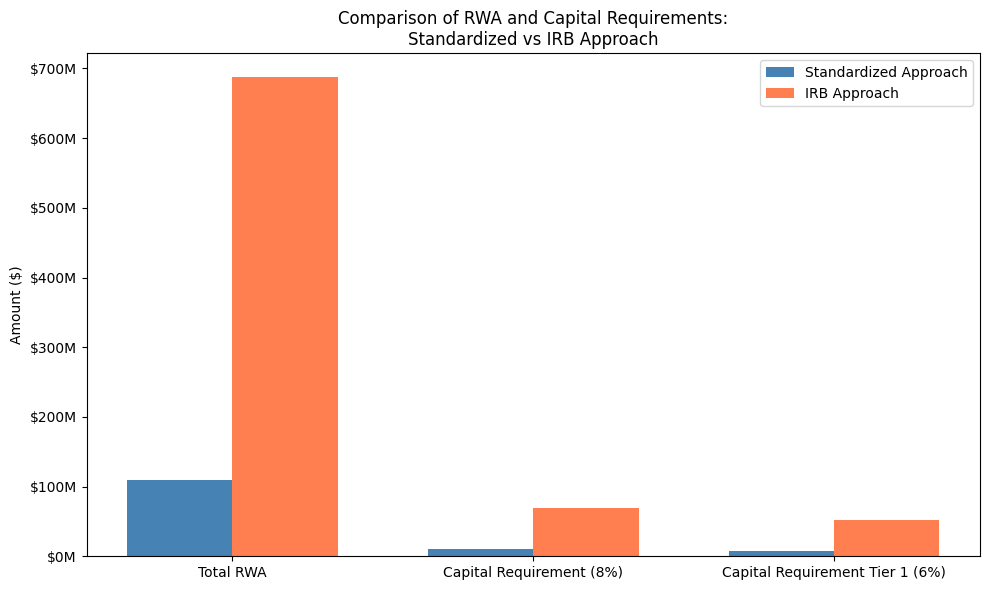

In [453]:
# Prepare data for visualization
labels = ['Total RWA', 'Capital Requirement (8%)', 'Capital Requirement Tier 1 (6%)']
std_values = [rwa_std_total, capital_std_total, cr_tier1_std_total]
irb_values = [rwa_irb_total, capital_irb_total, cr_tier1_irb_total]

# Create a bar chart comparing RWA and Capital Requirements between approaches
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x - width/2, std_values, width, label='Standardized Approach', color='steelblue')
rects2 = ax.bar(x + width/2, irb_values, width, label='IRB Approach', color='coral')

ax.set_ylabel('Amount ($)')
ax.set_title('Comparison of RWA and Capital Requirements:\nStandardized vs IRB Approach')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

plt.tight_layout()
plt.show()

### Insights and Recommendations

Key Insights:

- IRB RWA ($687.7M) is much higher than SA RWA ($109.8M), resulting in higher capital requirements. Which is expected as this reflects the more sensitive risk assessment under IRB.
- Capital Requirements: IRB requires $55.0M vs $8.8M under SA; Tier 1 capital mirrors this difference.
- Risk Weight: SA ~33% (moderate risk), IRB ~204% (some exposures considered high risk).

Recommendations:
- Banks could consider reviewing high-risk exposures flagged by the IRB model to ensure accurate PD and LGD estimates.
- Bank could use IRB results for strategic capital planning, as they better capture portfolio risk.
- If aiming to reduce capital requirements, explore risk mitigation techniques (e.g., collateral, guarantees).
- Maintain SA calculations for regulatory reporting and conservative benchmarking.